In [ ]:
import pandas as pd
import numpy as np

In [ ]:
d1 = pd.read_csv("/content/flabel12.csv")
d2 = pd.read_csv("/content/dataairport1.csv")
d3 = pd.read_csv("/content/datachruch1.csv")
d4 = pd.read_csv("/content/datahospital1.csv")
d5 = pd.read_csv("/content/datarestaurant.csv")
d6 = pd.read_csv("/content/datazoo1.csv")
data = pd.concat([d1,d3,d4,d5,d6])
data.shape

(131625, 5)

In [ ]:
data.drop_duplicates(subset=['Tweet'], inplace = True)
print("No of Unique tweets: ", data['Tweet'].count())

No of Unique tweets:  129715


In [ ]:
import nltk
import re, string
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword = stopwords.words('english')
print("Stopwords:",stopword)

Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean(text):
    text = text.lower() # lower case
    text = re.sub(r'https?://\S+|www\.\S+', " ", text)#URL
    text = re.sub(r'@\w+',' ',text) # mentions
    text = re.sub(r'#\w+', ' ', text) #hashtags
    text= re.sub(r'[^\w\s]',' ',text) #punctuations
    text= re.sub(r'\d+', ' ', text) #digits
    text = re.sub('\[.*?\]',' ', text) #any punctuations left
    text = re.sub("[^a-z0-9]"," ", text)# any others charcters other than numbers and letters
    text = text.split() #stopwords
    text = " ".join([word for word in text if not word in stopword])
    return text

In [ ]:
data['Tweet'] = data['Tweet'].astype(str).apply(lambda x: clean(x))
data['Tweet'].sample(5)

5573     burrito roulette day carnitas black beans roma...
74449             orlando international airport orlando fl
35997    please follow back best hospital amp greatest ...
2920     father revealed john kjv bible verse image can...
96958     happy new babies nash potomac coquil playing mom
Name: Tweet, dtype: object

In [ ]:
max_len = len(max(data['Tweet'], key=len))
print("Maximum length of Tweet:",max_len)

Maximum length of Tweet: 276


In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_tweets(tweets):
    temp = ""
    for w in tokenizer.tokenize(tweets):
      temp = temp + lemmatizer.lemmatize(w) +" " 
    return temp
data['Tweet'] = data['Tweet'].apply(lambda x: lemmatize_tweets(x))

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer()

def stem_tweets(tweets):
    temp = ""
    for w in tokenizer.tokenize(tweets):
      temp = temp + stemmer.stem(w) +" " 
    return temp
data['Tweet'] = data['Tweet'].apply(lambda x: stem_tweets(x))

In [ ]:
x = data['Tweet']
y = data['Label']

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import word2vec
from keras.models import Sequential,Model
from keras.layers import Dense,MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D,GlobalAveragePooling1D,Concatenate,Input
from keras.layers import Embedding, LSTM, Flatten, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam,Adadelta
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
import tensorflow as tf

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
vocab_length = len(tokenizer.word_index)+1
print("Length of Word Index:",vocab_length)
X = tokenizer.texts_to_sequences(x)
#encoded_sequence = [one_hot(s, vocab_length) for s in x ]
#print(encoded_sequence )
X = pad_sequences(X,maxlen = max_len, padding='post')

Length of Word Index: 37620


In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [ ]:
num_features = 300   # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    

w2v_model = word2vec.Word2Vec(data['Tweet'], workers=num_workers, 
            vector_size=num_features, min_count = min_word_count, 
            window = context)

w2v_model.init_sims(replace=True)

<ipython-input-144-c8569a3a6ce3>:10: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
embedding_dim = max_len
batch_size = 128
#drop_out = 0.5
num_epochs = 30

In [ ]:
from numpy import zeros
embedding_matrix = zeros((vocab_length, 300))

for word, i in tokenizer.word_index.items():
    # check if the word is in the word2vec vocab
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.70, shuffle=True,random_state=42,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_train,y_train, test_size=0.5,shuffle=True,random_state=42,stratify=y_train)

In [ ]:
X_val.shape


(45400, 276)

In [ ]:
X_train.shape

(90800, 276)

In [ ]:
X_test.shape

(45400, 276)

In [ ]:
embedding_matrix.shape

(37620, 300)

In [ ]:
model_input = Input(shape=(max_len, ))

model = Sequential()
e = Embedding(vocab_length,300, weights=[embedding_matrix], input_length=max_len)(model_input)

filter_sizes =[1,2,3,4]
num_filters = 128
conv_blocks = []
for sz in filter_sizes:
    conv=Conv1D(filters=num_filters,kernel_size=sz, activation='relu',kernel_regularizer=regularizers.l2(0.000001))(e)
    conv = MaxPooling1D(pool_size=2, strides =1 )(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
# z = Dense(32, activation="sigmoid")(z)
z = Dropout(0.5)(z)
model_output = Dense(5, activation="softmax")(z)

model = Model(model_input, model_output)
model.summary()

# compile the model
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt,loss = CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=30, verbose=1,
               callbacks=[early_stopping])


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 276)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 276, 300)     11286000    ['input_6[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 276, 128)     38528       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_21 (Conv1D)             (None, 275, 128)     76928       ['embedding_5[0][0]']            
                                                                                            

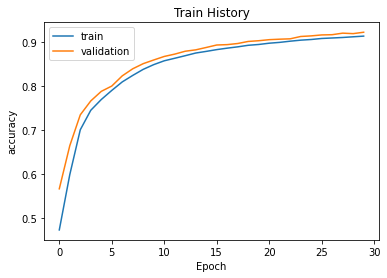

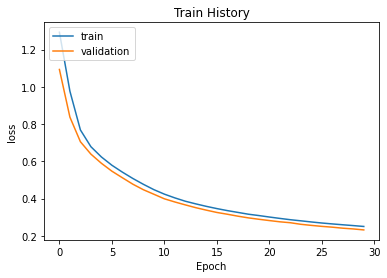

Accuracy on training data is:- 91.39757752418518 %
Loss 25.05117654800415
Accuracy on validation data is:- 92.27973818778992 %
Loss 23.197968304157257


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history.history[train])
    plt.plot(train_history.history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

show_train_history(model,'accuracy','val_accuracy')
show_train_history(model,'loss','val_loss') 
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")
print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [ ]:
pred6 = np.argmax(model.predict(X_test), axis =1)
slabels6=np.argmax(y_test, axis=1)
print("F1-score of LSTM CNN2Model:",f1_score(slabels6,pred6, average='macro'))
print(classification_report(slabels6,pred6))

1419/1419 [==============================] - 6s 4ms/step
F1-score of LSTM CNN2Model: 0.9040898694526407
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     15658
           1       0.91      0.95      0.93     13858
           2       0.87      0.88      0.88      6208
           3       0.93      0.88      0.91      6177
           4       0.90      0.83      0.86      3499

    accuracy                           0.92     45400
   macro avg       0.91      0.90      0.90     45400
weighted avg       0.92      0.92      0.92     45400



In [ ]:
#Confusion Matrix for GRU Layer Model:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(slabels6, pred6)
cm

array([[14828,   450,   190,    98,    92],
       [  299, 13118,   247,   113,    81],
       [  183,   330,  5469,   136,    90],
       [  152,   272,   220,  5462,    71],
       [  172,   215,   147,    67,  2898]])

<Axes: >

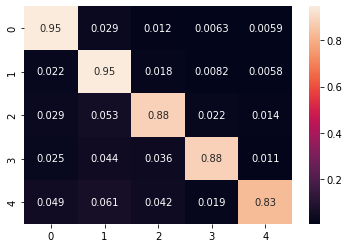

In [ ]:
import seaborn as sns
#Visualization of Confusion Matrix
cm2 = confusion_matrix(slabels6, pred6,normalize="true")
sns.heatmap(cm2,annot=True)